El oscilador de Duffing consiste en un oscilador forzado en el que la fuerza de restitución se encuentra dada por: $F_{rest}(x)=-\alpha x-\beta x^3$. Con esto, el oscilador se encuentra descrito por la ecuación:

$$\ddot{x}+\delta\dot{x}+\alpha x+\beta x^3=\gamma cos(\omega t)$$.

## Solución Por RK4

In [57]:
import numpy as np
import pylab as pl
from random import *
import timeit
import scipy.integrate as spi
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [71]:
def arg_rk4(funcion,x0,tlist,args=0,h=0.1):
    """
    Funcion de Integracion por el Metodo de Runge-Kutta a 4o orden. Sus argumentos son: la funcion de la ecuacion diferencial,
    el valor de la funcion al tiempo inicial x0,una lista con el tiempo inicial y el final tlist=[ti,tf] y 
    el paso de integracion como argumento opcional. 
    Puede tener una lista de parametros opcionales args que se pasan a la funcion de la ecuacion diferencial.
    Regresa los tiempos y sus respectivos valores de la funcion como una tupla de arrays t,x. 
    Cabe notar que la funcion, el jacobiano y x0 pueden tomar valores vectoriales, los cuales se representan por arrays.
    Tambien, la funcion debe tener ordenados los parámetros de la forma g(t,x).
    """
    if (tlist[1]-tlist[0])<10.0*h:   #cambia el valor de h para garantizar que se hagan almenos 10 iteraciones
        h=(tlist[1]-tlist[0])*0.1
    tiempos=np.arange(tlist[0],tlist[1],h) #regresa un array
    x = np.zeros((len(tiempos),len(x0)))#regresa otro array del ancho de la dimension de x0 y el largo del array de tiempos)
    x[0,:] = x0 #x[tiempo,coordenada],:==todas las coordenadas
    if args == 0:  #no hay argumentos opcionales dados    
        for i in xrange(0,len(tiempos)-1):
            k1=funcion(x[i,:],tiempos[i])
            k2=funcion(x[i,:]+0.5*h*k1,tiempos[i]+0.5*h)
            k3=funcion(x[i,:]+0.5*h*k2,tiempos[i]+0.5*h)
            k4=funcion(x[i,:]+h*k3,tiempos[i]+h)
            x[i+1,:]=x[i,:]+(1/6.0)*h*(k1+2*k2+2*k3+k4)    
    else:
        for i in xrange(0,len(tiempos)-1):
            k1=funcion(x[i,:],tiempos[i],*args)
            k2=funcion(x[i,:]+0.5*h*k1,tiempos[i]+0.5*h,*args)
            k3=funcion(x[i,:]+0.5*h*k2,tiempos[i]+0.5*h,*args)
            k4=funcion(x[i,:]+h*k3,tiempos[i]+h,*args)
            x[i+1,:]=x[i,:]+(1/6.0)*h*(k1+2*k2+2*k3+k4)    
    return tiempos,x 
#regresa una tupla, que la hace inmutable a diferencia de una lista y que, a diferencia de un array, 
#cada entrada puede ser de distinto tipo (heterogéneas)

Para obtener la ecuación de movimiento, hacemos el cambio de variable $\begin{cases}x_1=x(t) \\x_2=\dot{x}(t) \end{cases} \Rightarrow \dot{x_2}=\ddot{x}(t)$. Entonces, se tiene que $\begin{cases}\dot{x_1}=x_2 \\ \dot{x_2}=\gamma cos(\omega t)-\delta x_2-\alpha x_1-\beta x_1^3  \end{cases}$

Por tanto, el sistema se puede escribir como $\dot{\vec{x}}=\vec{g}(t,\vec{x})$, con $\vec{x}=(x_1,x_2)$ y $\vec{g}=(x_2,\gamma cos(\omega t)-\delta x_2-\alpha x_1-\beta x_1^3)$.

In [72]:
def ec_mov(x,t,alpha=5.,beta=1.,gamma=0.5,delta=0.2,omega=1.5): #x=(x1,x2)=(x,dx)
    dx1=x[1]
    dx2=gamma*np.cos(omega*t)-delta*x[1]-alpha*x[0]-beta*x[0]**3
    return np.array([dx1,dx2]) #regresa un array  

Tomaremos los parámetros $\alpha=-1, \beta=1,\gamma=0.3, \delta=0.2, \omega=1.$

Barreremos los parámetros para ver qué pasa con esto:

Wall time: 300 ms
Wall time: 19 ms


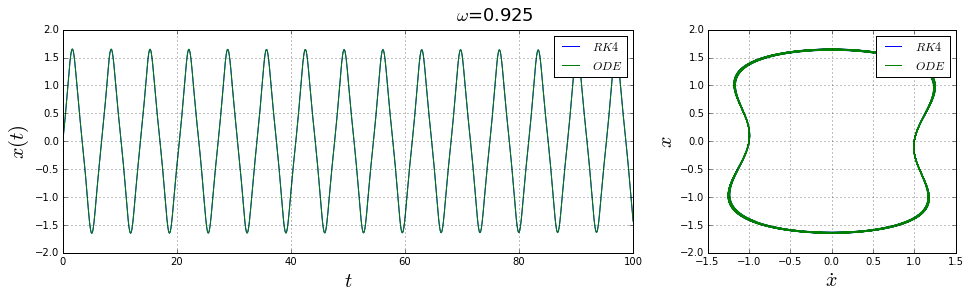

Wall time: 299 ms
Wall time: 16 ms


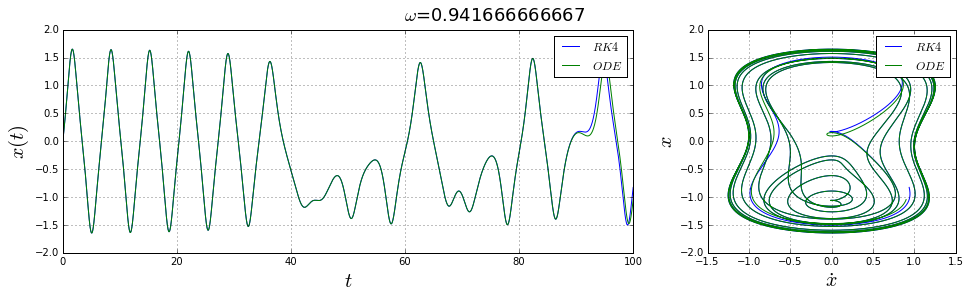

Wall time: 308 ms
Wall time: 17 ms


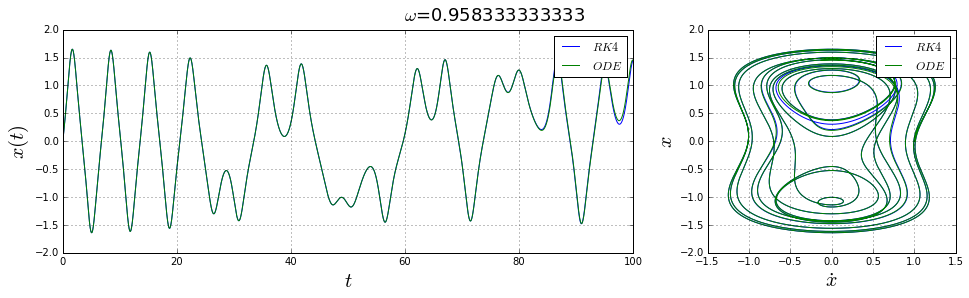

Wall time: 335 ms
Wall time: 16 ms


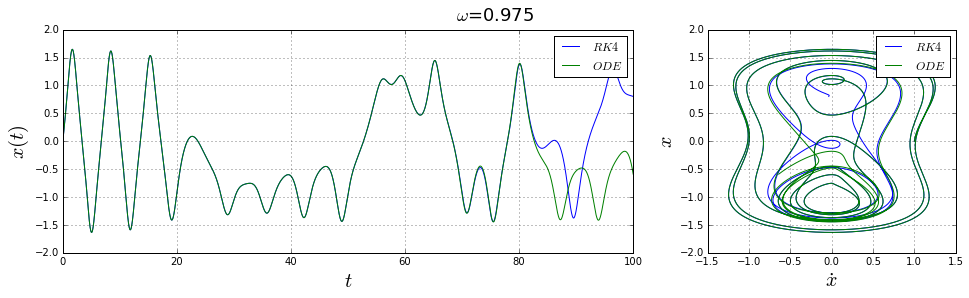

Wall time: 296 ms
Wall time: 14 ms


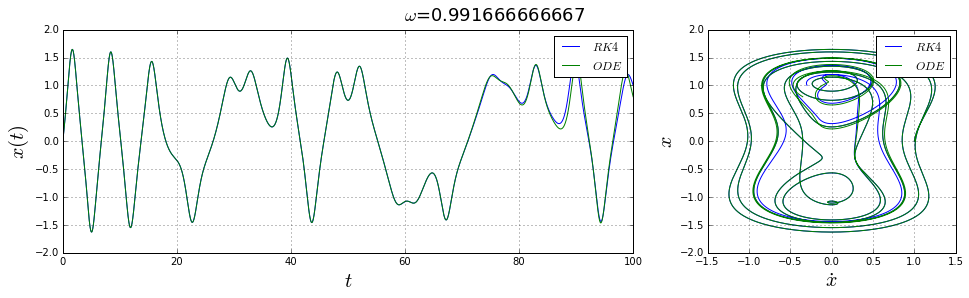

Wall time: 284 ms
Wall time: 14 ms


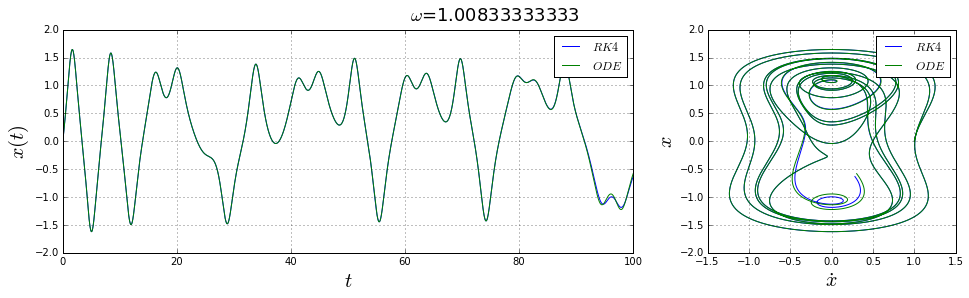

Wall time: 280 ms
Wall time: 15 ms


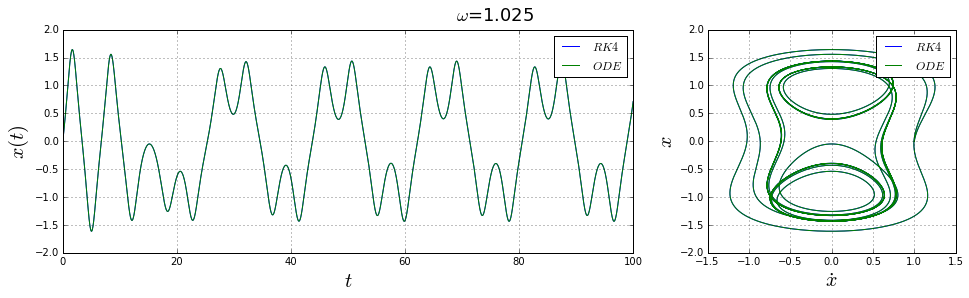

Wall time: 294 ms
Wall time: 14 ms


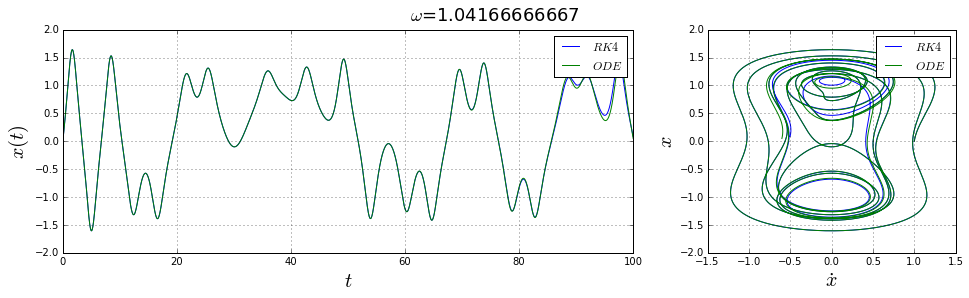

Wall time: 357 ms
Wall time: 17 ms


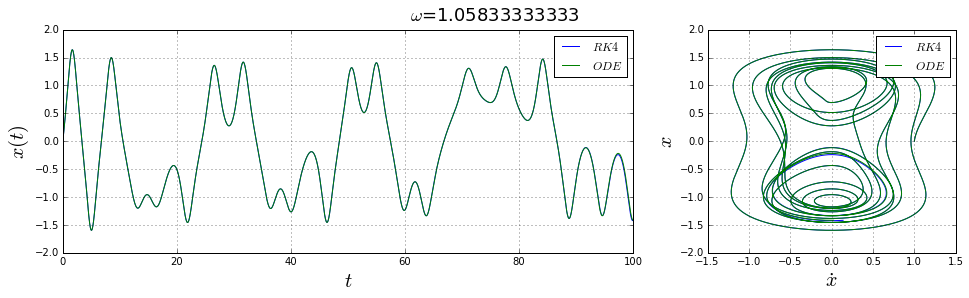

Wall time: 303 ms
Wall time: 17 ms


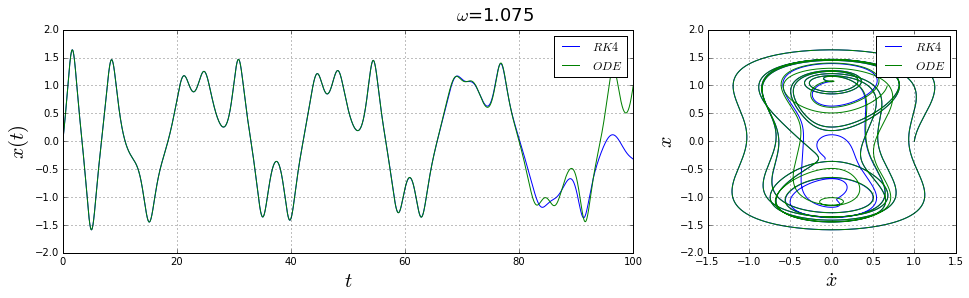

In [98]:
paso=0.01
x0=[0,1]
tf=100
tiempos=np.arange(0,100,paso)
lista_omegas=np.linspace(0.925,1.075,10).tolist()

for i,omega in enumerate(lista_omegas):
    args=(-1.,1.,0.3,0.2,omega) #explota con alpha=1, beta=-1
    %time t,sol_rk4=arg_rk4(ec_mov,x0,[0,tf],args,h=paso)
    %time sol_ode=spi.odeint(ec_mov,x0,tiempos,args=args)
    
    fig=plt.figure(figsize=(16,4))
    fig.suptitle('$\omega$={}'.format(omega),fontsize=18)
    gs=gridspec.GridSpec(1, 3,wspace=0.3)
    ax1 = plt.subplot(gs[0, :-1])
    ax2 = plt.subplot(gs[0, -1])
    
    ax1.plot(t,sol_rk4[:,0],label="$RK4$")
    ax1.plot(t,sol_ode[:,0],label="$ODE$")
    ax1.set_ylabel('$x(t)$',fontsize=20)
    ax1.set_xlabel('$t$',fontsize=20)
    ax1.legend()
    ax1.grid()
    
    ax2.plot(sol_rk4[:,1],sol_rk4[:,0],label="$RK4$")
    ax2.plot(sol_ode[:,1],sol_ode[:,0],label="$ODE$")
    ax2.set_ylabel('$x$',fontsize=20)
    ax2.set_xlabel('$\dot{x}$',fontsize=20)
    ax2.legend()
    ax2.grid()
    plt.show()

Ahora haremos un barrido de otros parámetros

Wall time: 291 ms
Wall time: 14 ms


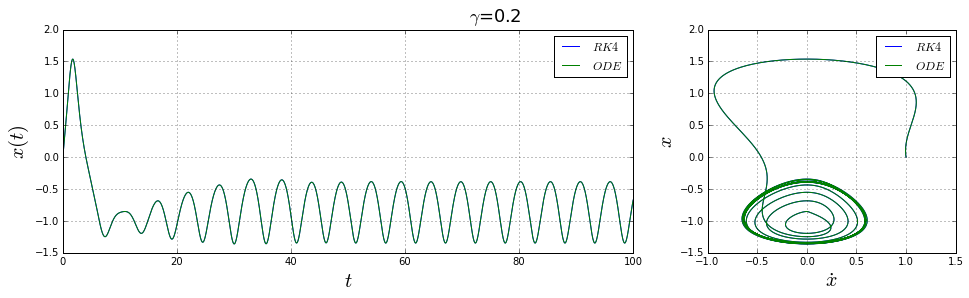

Wall time: 336 ms
Wall time: 15 ms


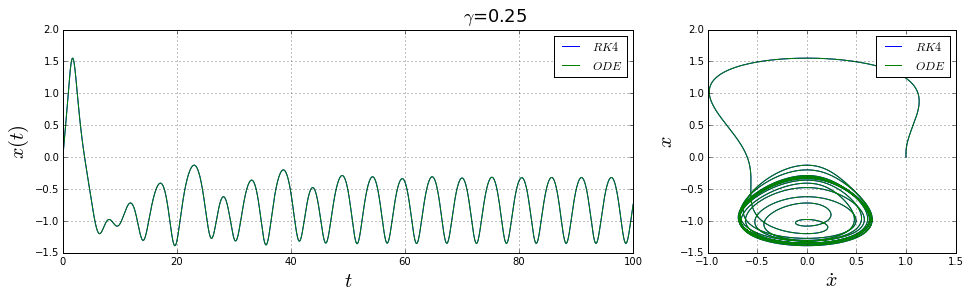

Wall time: 341 ms
Wall time: 16 ms


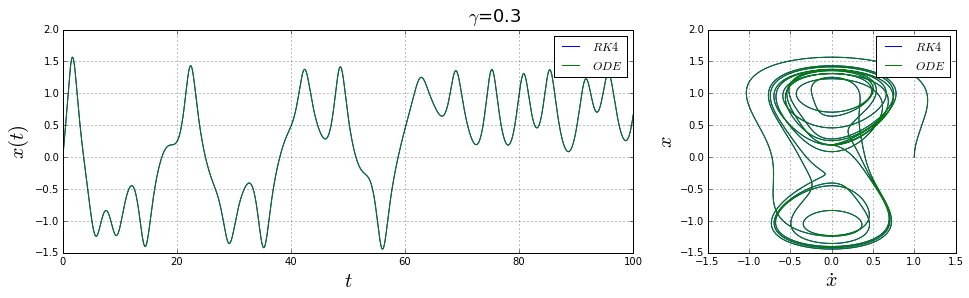

Wall time: 296 ms
Wall time: 15 ms


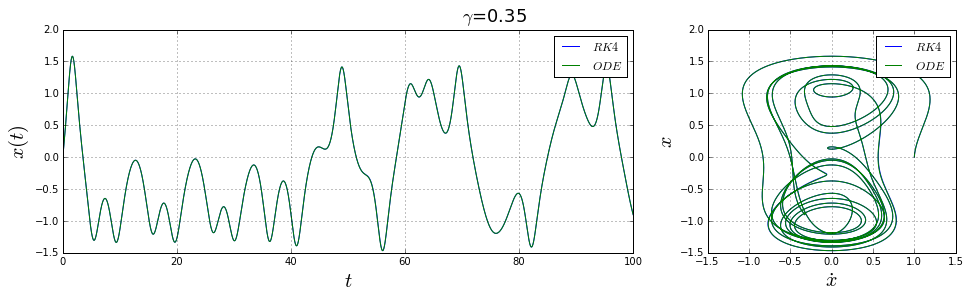

Wall time: 292 ms
Wall time: 13 ms


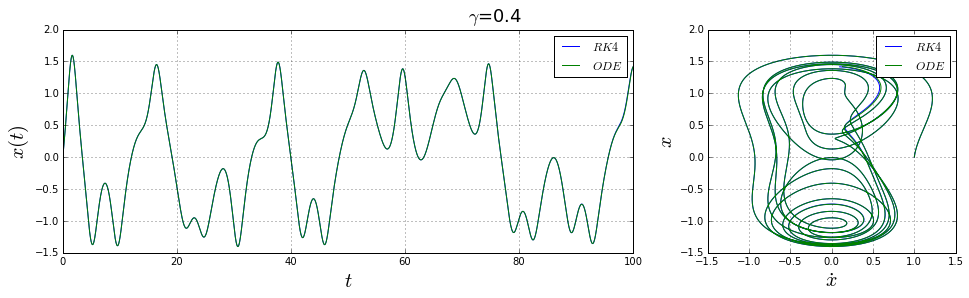

Wall time: 329 ms
Wall time: 13 ms


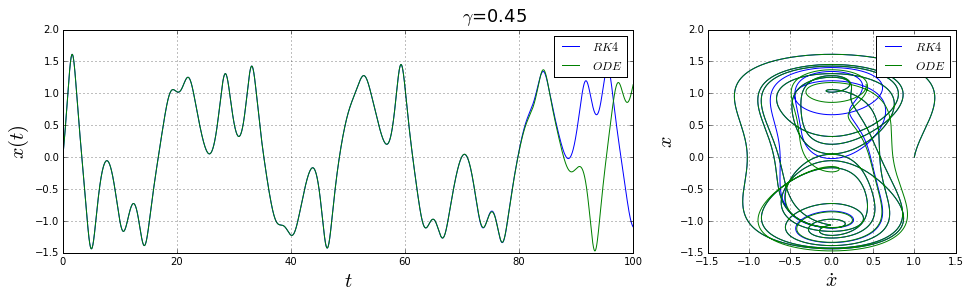

Wall time: 319 ms
Wall time: 15 ms


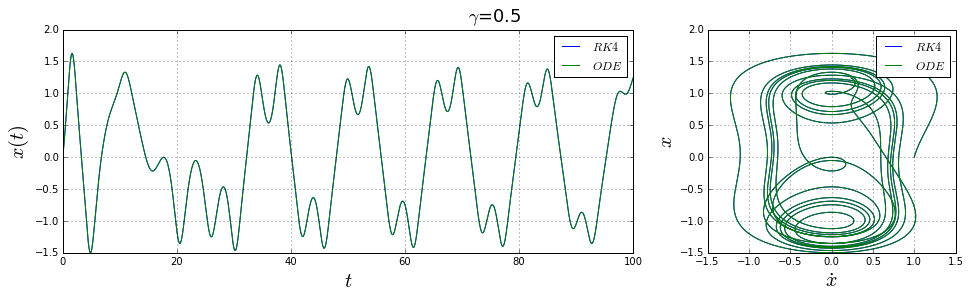

Wall time: 301 ms
Wall time: 15 ms


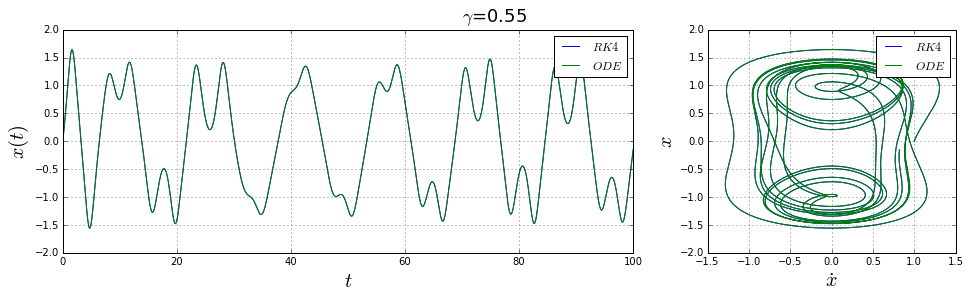

Wall time: 286 ms
Wall time: 15 ms


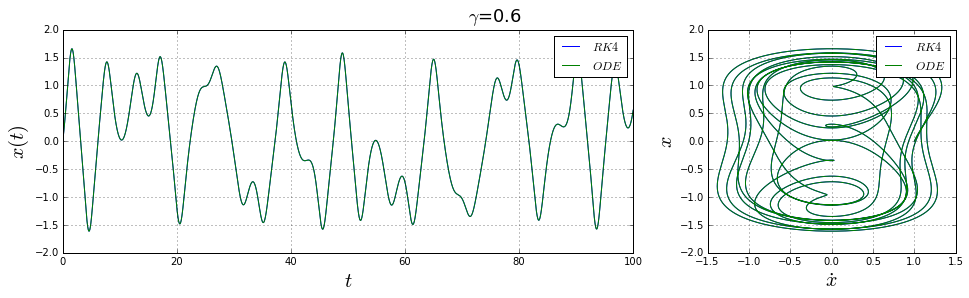

Wall time: 297 ms
Wall time: 18 ms


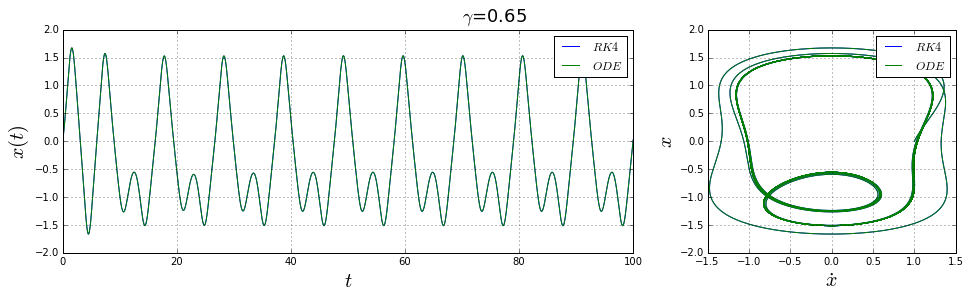

In [102]:
paso=0.01
x0=[0,1]
tf=100
tiempos=np.arange(0,100,paso)
lista_gammas=np.linspace(0.20,0.65,10).tolist()

for i,gamma in enumerate(lista_gammas):
    args=(-1.,1.,gamma,0.3,1.2) #explota con alpha=1, beta=-1
    %time t,sol_rk4=arg_rk4(ec_mov,x0,[0,tf],args,h=paso)
    %time sol_ode=spi.odeint(ec_mov,x0,tiempos,args=args)
    
    fig=plt.figure(figsize=(16,4))
    fig.suptitle('$\gamma$={}'.format(gamma),fontsize=18)
    gs=gridspec.GridSpec(1, 3,wspace=0.3)
    ax1 = plt.subplot(gs[0, :-1])
    ax2 = plt.subplot(gs[0, -1])
    
    ax1.plot(t,sol_rk4[:,0],label="$RK4$")
    ax1.plot(t,sol_ode[:,0],label="$ODE$")
    ax1.set_ylabel('$x(t)$',fontsize=20)
    ax1.set_xlabel('$t$',fontsize=20)
    ax1.legend()
    ax1.grid()
    
    ax2.plot(sol_rk4[:,1],sol_rk4[:,0],label="$RK4$")
    ax2.plot(sol_ode[:,1],sol_ode[:,0],label="$ODE$")
    ax2.set_ylabel('$x$',fontsize=20)
    ax2.set_xlabel('$\dot{x}$',fontsize=20)
    ax2.legend()
    ax2.grid()
    plt.show()

Ahora definimos el mapeo de Poincaré para una trayectoria específica. Lo que haremos es fijarnos en un punto de la trayectoria después de que transurra un periodo del forzamiento, i.e. $t=2\pi \omega n$.

In [ ]:
def Mapeo_Poincare(ec_mov,xini,tlist,alpha=5.,beta=1.,gamma=0.5,delta=0.2,omega=1.5): #x=(x1,x2)=(x,dx), tlist=[t0,tf]
    